In [1]:
%matplotlib inline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

In [2]:
from prototype_data import get_dataset
%run prototype_plots.py

/mnt/Data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
random_seed = 24
np.random.seed(random_seed)

In [4]:
data_name = 'cifar10'
data = get_dataset(data_name, random_seed=random_seed)

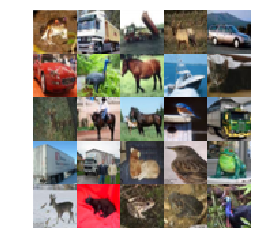

In [5]:
X_imgs, X, y = data.gen_data(plot=True)
skf, skf_cv = data.splitters(train_size=1000,cv_repeats=10)
train, test = list(skf.split(X,y))[0]
scaler = StandardScaler()
X = scaler.fit(X[train]).transform(X)

explained variance  [163.27744   56.611652  48.578094  40.67983   38.46973 ]


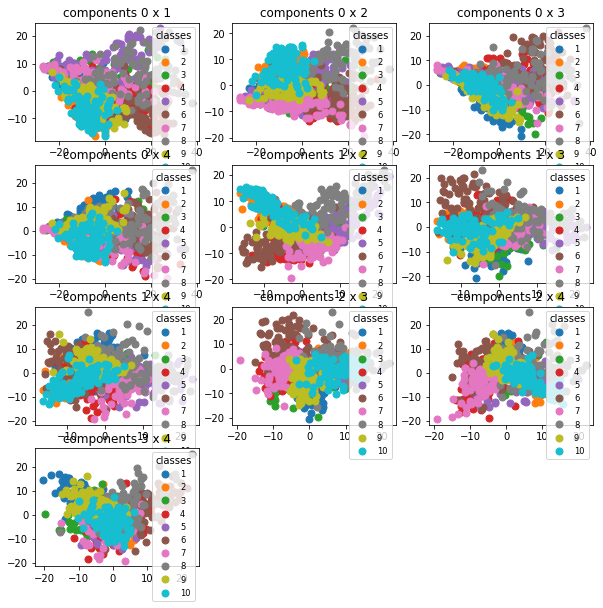

In [6]:
plot2D(X[train],y[train], n_components=5, random_state=random_seed)
plt.gcf().set_size_inches(10,10)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=24, verbose=0)

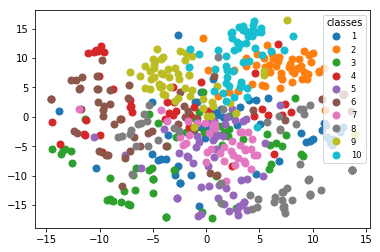

In [7]:
plot2D(X[train],y[train], method='tsne',
       plot_n_samples=500,
       random_state=random_seed)

## Quick recap of sklearn's PCA module

- sklearn has PCA and TruncatedSVD
- the main difference is that PCA centers the data first
- another difference are the solvers available: only PCA has full (lapack), otherwise it uses trucatedsvd (arpack) or randomized svd (both available under Truncated SVD)
- arpack warining:  ARPACK can be unstable for some problems. It is best to try several random seeds in order to check results. (from lle sklearn doc)
    - I have observed bad results (all eigen values being equal) after some runs

In [8]:
n_components = 100

In [9]:
# About PCA
# PCA centers the data before calling some svd solver routine
# besides the centering it is equivalent to svd
pca = PCA(
    n_components=n_components, 
    whiten='false',
    svd_solver='full', # ‘full’ (lapack), ‘arpack’, ‘randomized’
    tol=0.0, # only for arpack
    iterated_power='auto',  # used for randomized
    random_state=random_seed)  # used for arpack or randomized

In [10]:
# About truncated SVD
# This estimator supports two algorithms: a fast randomized SVD solver, 
# and a “naive” algorithm that uses ARPACK as an eigensolver on (X * X.T) 
# or (X.T * X), whichever is more efficient.
svd = TruncatedSVD(
    n_components=n_components, 
    algorithm='arpack', # arpack or randomized
    n_iter=5, # only used for randomized
    tol=0.0, # only for arpack
    random_state=random_seed) #used for arpack

In [11]:
# center features and compare to PCA results
svd.fit(X[train]-X[train].mean(axis=0))

TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=24,
       tol=0.0)

In [12]:
pca.fit(X[train])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=24,
  svd_solver='full', tol=0.0, whiten='false')

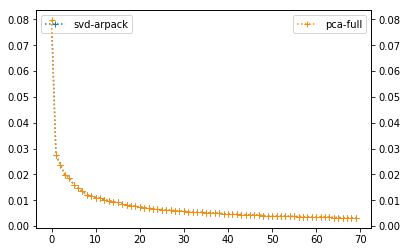

In [13]:
plt.plot(svd.explained_variance_ratio_[0:70], marker='+', linestyle=':',
        label='svd-arpack')
plt.legend(loc='upper left')
ax2 = plt.gca().twinx()
ax2.plot(pca.explained_variance_ratio_[0:70], marker='+', linestyle=':',
        label='pca-full', color='darkorange')
plt.legend(loc='best')

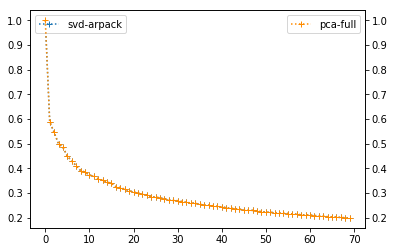

In [14]:
plt.plot(svd.singular_values_[0:70]/svd.singular_values_[0],
         marker='+', linestyle=':',
        label='svd-arpack')
plt.legend(loc='upper left')
ax2 = plt.gca().twinx()
ax2.plot(pca.singular_values_[0:70]/pca.singular_values_[0], 
         marker='+', linestyle=':',
        label='pca-full', color='darkorange')
plt.legend(loc='best')

## LLE and Laplacien eignemaps (spectral embedding)

- Both modules in sklearn can use arpack solver.
- only lle allows full eignvalue copmutation
- spectral embedding has arpack and other randomized solvers

In [15]:
n_neighbors = 10
n_components_range = np.arange(5, 50, 5)

### LLE

In [16]:
# about lle
# reconstruction_error_:
# norm(Y - W Y, 'fro')**2
# Y is the embedding
lle = LocallyLinearEmbedding(
    n_neighbors=n_neighbors,
    n_components=n_components,
    eigen_solver='dense',  # arpack or dense
    reg=0.001,
    tol=1e-06,  # only for arpack
    max_iter=100,  # only for arpack
    method='standard',  # ‘standard’, ‘hessian’, ‘modified’ or ‘ltsa’
    hessian_tol=0.0001, 
    modified_tol=1e-12, 
    neighbors_algorithm='auto', # ’brute’|’kd_tree’|’ball_tree’
    random_state=random_seed,  # used for arpack
    n_jobs=-1)

In [17]:
lles = []
for n in n_components_range:
    lle_i = clone(lle)
    lle_i.set_params(n_components=n)
    lle_i.fit(X[train])
    lles.append(lle_i)

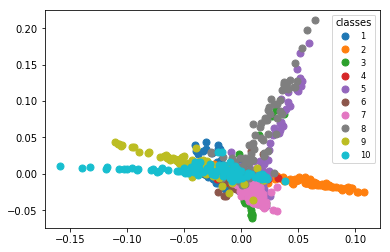

In [37]:
plot2D(lles[-1].embedding_[:,[2,3]], y[train])

#### surpise 1 : reconstruction error growing with n components??

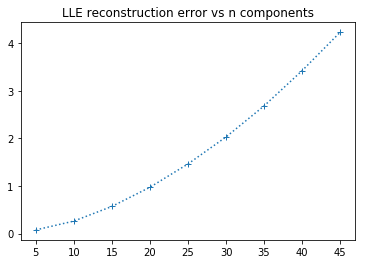

In [18]:
err_lle = [emb.reconstruction_error_ for emb in lles]
plt.title('LLE reconstruction error vs n components')
plt.plot(n_components_range,err_lle, '+:')


### PCA over the LLE embedding space

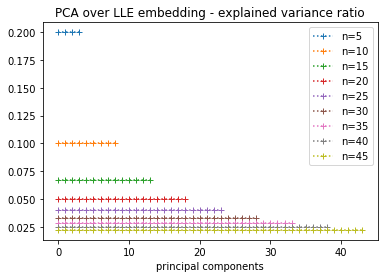

In [19]:
for emb in lles:
    pca_ = clone(pca)
    pca_.set_params(n_components=emb.n_components-1)
    pca_.fit(emb.embedding_)
    var = pca_.explained_variance_ratio_
    plt.plot(var, '+:', label='n=%d' % emb.n_components)
plt.title('PCA over LLE embedding - explained variance ratio')
plt.xlabel('principal components')
plt.legend()

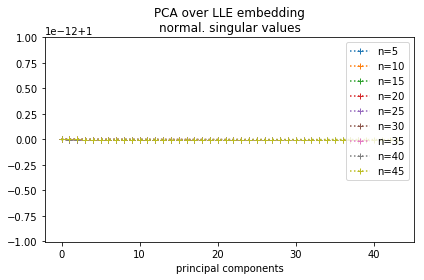

In [20]:
for emb in lles:
    pca_ = clone(pca)
    pca_.set_params(n_components=emb.n_components-1)
    pca_.fit(emb.embedding_)
    var = pca_.singular_values_/pca_.singular_values_[0]
    plt.plot(var, '+:', label='n=%d' % emb.n_components)
plt.title('PCA over LLE embedding\nnormal. singular values')
plt.xlabel('principal components')
plt.legend()
plt.tight_layout()

## Laplacien eignenmap - Spectral embedding

In [21]:
# About SpectralEmbedding
# Computes kNN graph with algorithm='auto'
laplacien_eig = SpectralEmbedding(
    n_components=n_components, 
    eigen_solver='arpack', # arpack, lobpcg or amg (requires pyamg package)
    random_state=random_seed, 
    affinity='nearest_neighbors',
    gamma=None,  # used for affinity rbf
    n_neighbors=n_neighbors, # used for affinity nearest_neighbors
    n_jobs=-1)

In [22]:
laplacien_eigs = []
for n in n_components_range:
    le_i = clone(laplacien_eig)
    le_i.set_params(n_components=n)
    le_i.fit(X[train])
    laplacien_eigs.append(le_i)

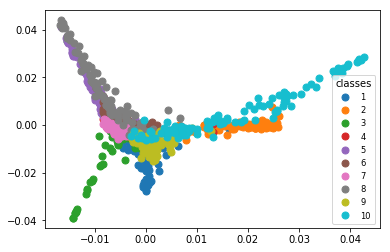

In [39]:
plot2D(laplacien_eigs[-1].embedding_[:,[0,1]], y[train])

### PCA over the Spectral embedding space

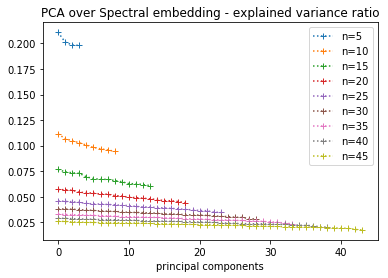

In [24]:
for emb in laplacien_eigs:
    pca_ = clone(pca)
    pca_.set_params(n_components=emb.n_components-1)
    pca_.fit(emb.embedding_)
    var = pca_.explained_variance_ratio_
    plt.plot(var, '+:', label='n=%d' % emb.n_components)
plt.title('PCA over Spectral embedding - explained variance ratio')
plt.xlabel('principal components')
plt.legend()

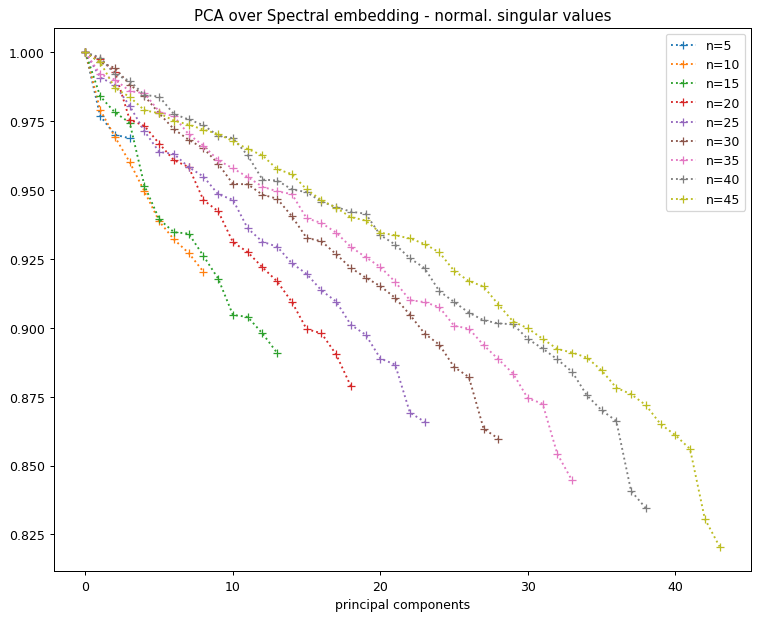

In [25]:
plt.figure(figsize=(10,8),dpi=90)
for emb in laplacien_eigs:
    pca_ = clone(pca)
    pca_.set_params(n_components=emb.n_components-1)
    pca_.fit(emb.embedding_)
    var = pca_.singular_values_/pca_.singular_values_[0]
    plt.plot(var, '+:', label='n=%d' % emb.n_components)
plt.title('PCA over Spectral embedding - normal. singular values')
plt.xlabel('principal components')
plt.legend()


## PCA over all embeddings

In [26]:
pca_emb = {}
embs = [laplacien_eigs[-2], lles[-2]]
for emb in embs:
    pca_ = clone(pca)
    pca_.set_params(n_components=emb.n_components-1)
    label=emb.__class__.__name__.split('.')[-1]
    pca_emb[label] = pca_.fit(emb.embedding_)

In [28]:
vals = pca.singular_values_[0:emb.n_components-1]/pca.singular_values_[0]
plt.plot(vals, '+:',
        label='Original features')
for ix, emb in enumerate(embs):
    label=emb.__class__.__name__.split('.')[-1]
    pca_ = pca_emb[label].fit(emb.embedding_)
    var = pca_.singular_values_/pca_.singular_values_[0]
    plt.plot(var, '+:', label=emb.__class__.__name__.split('.')[-1])
plt.title('PCA over different embeddings - normal. singular values')
plt.xlabel('principal components')
plt.legend()